# Spectral analysis of Krylov subspace

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
from joblib import Parallel, delayed
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import pylab
import imageio
from sklearn.gaussian_process.kernels import Matern

In [2]:
def matern_covariance(N, length_scale=0.1):
    kernel = Matern(length_scale=0.1)
    x, y = np.meshgrid(np.linspace(-0.5, 0.5, N), np.linspace(-0.5, 0.5, N))
    covariance = kernel(np.array([x.ravel(), y.ravel()]).T)
    return covariance
    
def krylov_coefs_correlated_ensamble(solver, noise_dataset, degree):
    grid = pynoisy.utils.get_grid()
    input_noise = noise_dataset.isel(sample=np.random.randint(0, noise_dataset.sizes['sample'], solver.num_frames))
    input_noise = input_noise.interp_like(grid).swap_dims({'sample': 't'}).assign_coords(
        {'t':np.linspace(0, 0.1, solver.num_frames)}).drop('sample')
    measurements = solver.run_symmetric(source=input_noise)
    return krylov_coefs(measurements, solver, degree)

def krylov_coefs_ensamble(solver_m, solver_f, degree, seed=None):
    solver_m.reseed(seed)
    measurements = solver_m.run_symmetric(seed=seed)
    return krylov_coefs(measurements, solver_f, degree)

def krylov_coefs(measurements, solver, degree):
    forward_fn = lambda source: solver.run_symmetric(source, verbose=False)
    k_matrix = pynoisy.utils.get_krylov_matrix(measurements, forward_fn, degree)
    coefs = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=None)[0]
    return coefs 

## Opening angle

In [159]:
n_samples = 100
n_jobs = 20

advection = pynoisy.advection.disk()
diffusion = pynoisy.diffusion.ring()
solver_measure = pynoisy.forward.NoisySolver(advection, diffusion)
solver_forward = solver_measure.copy()
    
opening_angles = [diffusion.opening_angle, 0.5, 0.0]
degrees = [3, 8, 12]

coef_dataset = []
for degree in tqdm(degrees, desc='degrees'):
    coefs = []
    for angle in tqdm(opening_angles, desc='opening angles', leave=False):
        solver_forward.update_diffusion(pynoisy.diffusion.ring(opening_angle=angle))
        coefs.append(Parallel(n_jobs=n_jobs)(
            delayed(krylov_coefs_ensamble)(solver_measure, solver_forward, degree=degree) for i in 
            tqdm(range(n_samples), desc='random samples', leave=False)
        ))

    coefs = xr.DataArray(np.array(coefs), dims=['opening_angle', 'sample', 'degree'],
                         coords={'opening_angle': opening_angles, 
                                 'sample': range(n_samples), 'degree': range(degree)})
    coefs.name = 'krylov{}'.format(degree)
    coef_dataset.append(coefs)
    
coef_dataset = xr.merge(coef_dataset)
coef_dataset.to_netcdf('krylov spectrum/opening_angle_dataset.nc')

<IPython.core.display.Javascript object>


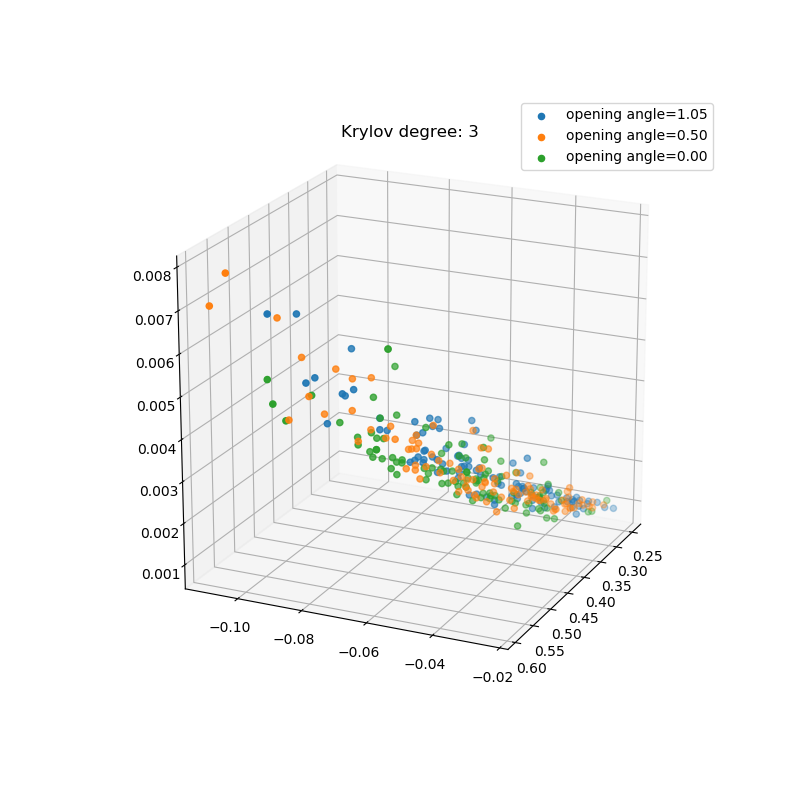

In [192]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov degree: 3')
for angle in coef_dataset.opening_angle:
    ax.scatter(*coef_dataset.krylov3.sel(opening_angle=angle, degree=range(3)).transpose('degree', 'sample'), 
               label='opening angle={:2.2f}'.format(angle.data))
    
plt.legend(loc='best')

<IPython.core.display.Javascript object>


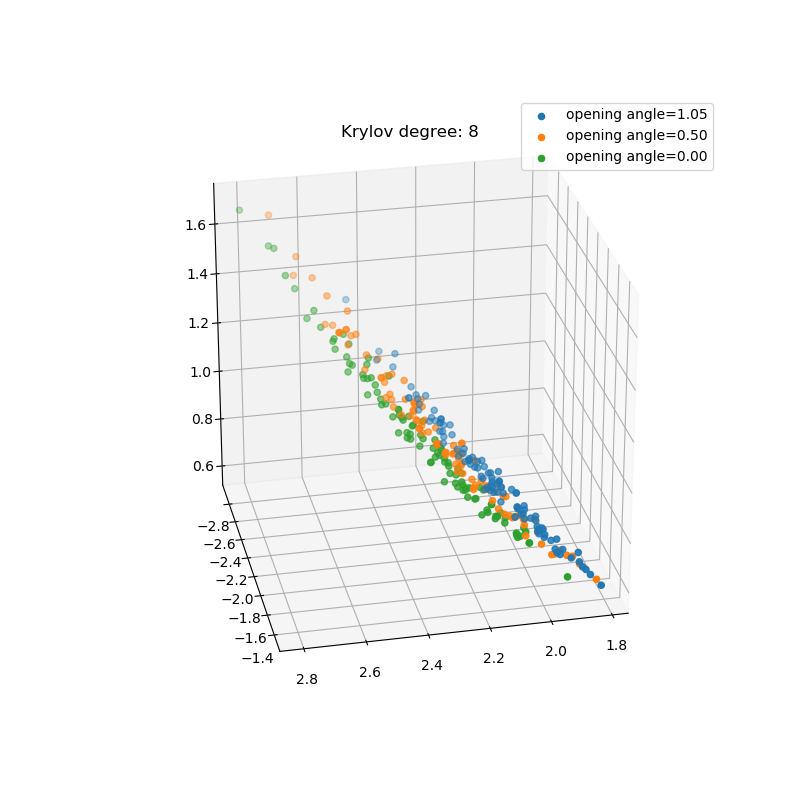

In [193]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov degree: 8')
for angle in coef_dataset.opening_angle:
    ax.scatter(*coef_dataset.krylov8.sel(opening_angle=angle, degree=range(3)).transpose('degree', 'sample'), 
               label='opening angle={:2.2f}'.format(angle.data))
plt.legend(loc='best')

## Noisy optimization

In [67]:
directory = '../runs/full_opt/'
true_solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'true_solver.nc'))
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'test1/final_solver.nc'))

n_samples = 100
n_jobs = 20
degree = 8

coefs0 = Parallel(n_jobs=n_jobs)(
    delayed(krylov_coefs_ensamble)(true_solver, true_solver, degree=degree) for i in 
    tqdm(range(n_samples), desc='random samples', leave=False))
coefs1 = Parallel(n_jobs=n_jobs)(
    delayed(krylov_coefs_ensamble)(true_solver, solver, degree=degree) for i in 
    tqdm(range(n_samples), desc='random samples', leave=False))
coefs2 = Parallel(n_jobs=n_jobs)(
    delayed(krylov_coefs_ensamble)(solver, solver, degree=degree) for i in 
    tqdm(range(n_samples), desc='random samples', leave=False))

noisy_optimization = {'True-True': coefs0, 'True-False': coefs1, 'False-False': coefs2}

<IPython.core.display.Javascript object>


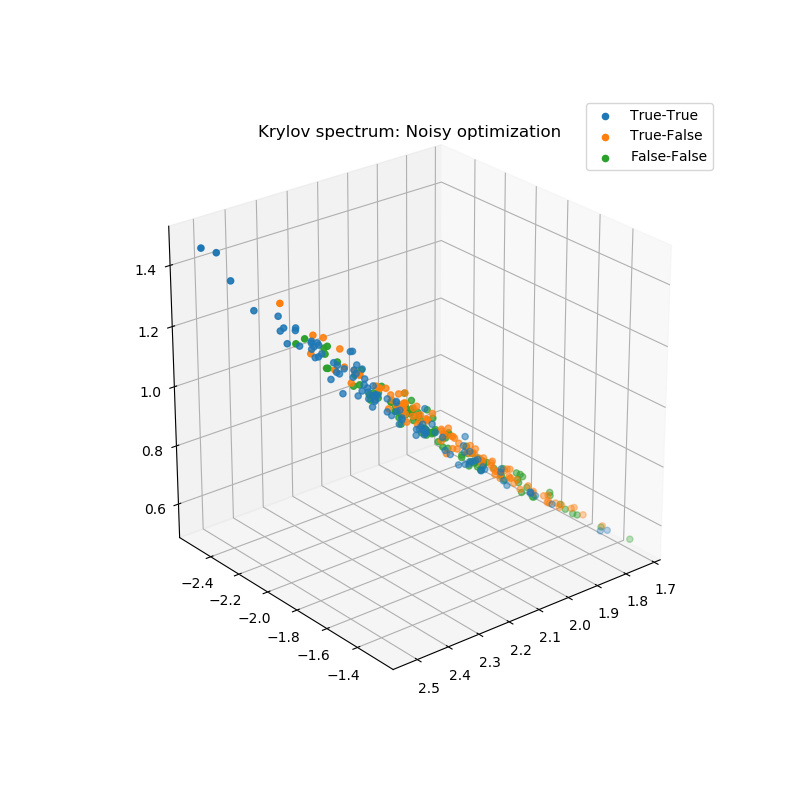

In [68]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov spectrum: Noisy optimization')

for key, value in noisy_optimization.items():
    ax.scatter(*list(zip(*value))[:3], label=key)
plt.legend(loc='best')

## GRMHD optimization 

In [ ]:
directory = '../runs/GRMHD/02/'
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory, 'ccw_rotation_init/final_solver.nc'))
measurements = xr.load_dataarray(os.path.join(directory,'measurements.nc'))
n_samples = 100
n_jobs = 20
degree = 8

krylov_fit = krylov_coefs(measurements, solver, degree)
noisy_coefs = Parallel(n_jobs=n_jobs)(
    delayed(krylov_coefs_ensamble)(solver, solver, degree=degree) for i in 
    tqdm(range(n_samples), desc='random samples', leave=False))

grmhd_optimization = {
    'noisy_coefs': noisy_coefs,
    'krylov_fit_coefs': krylov_fit,}

<IPython.core.display.Javascript object>


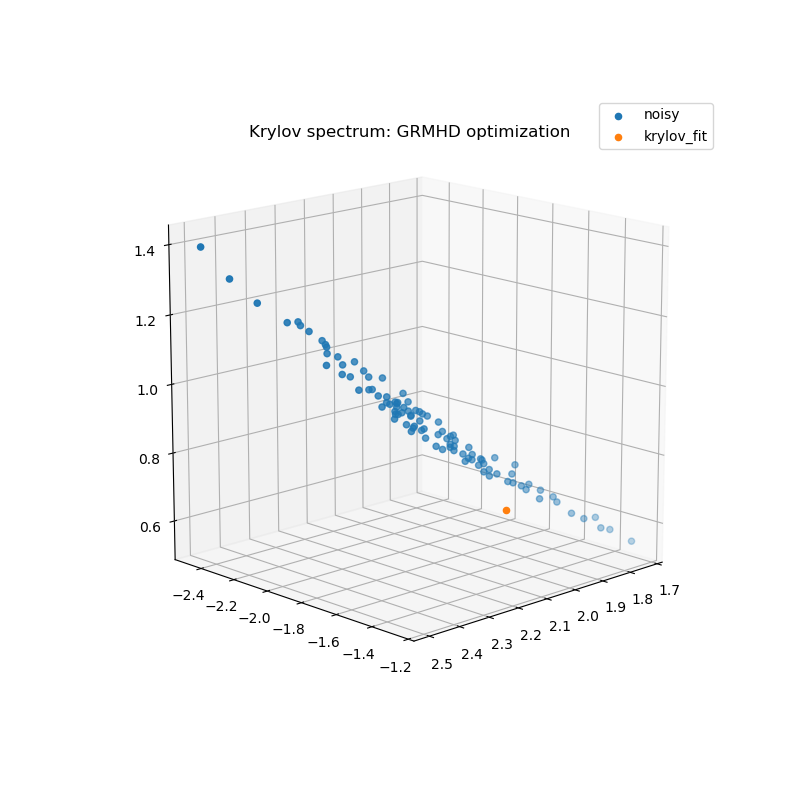

In [238]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov spectrum: GRMHD optimization')
ax.scatter(*list(zip(*grmhd_optimization['noisy_coefs']))[:3], label='noisy')
ax.scatter(*grmhd_optimization['krylov_fit_coefs'][:3], label='krylov_fit')
plt.legend(loc='best')

## Random angle

In [234]:
directory = '../runs/prior_checks/priniple_angle_init[zero]_krylovdeg[8]_mask[disk]_prior[False]_seed[18177]/'
solver_true = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(directory,'ground_truth.nc'))

n_samples = 100
n_jobs = 20
degree = 8

coefs = Parallel(n_jobs=n_jobs)(
    delayed(krylov_coefs_ensamble)(solver_true, solver_true, degree=degree) for i in 
    tqdm(range(n_samples), desc='random samples'))

<IPython.core.display.Javascript object>


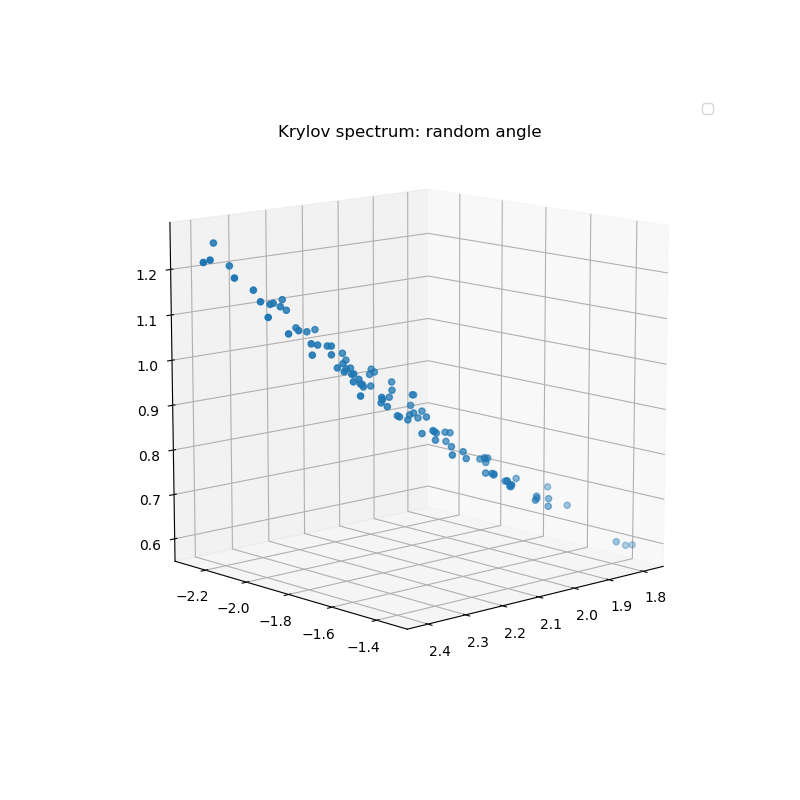

No handles with labels found to put in legend.


In [237]:
%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov spectrum: random angle')
ax.scatter(*list(zip(*coefs))[:3])
plt.legend(loc='best')

## Multivariate Noise

In [4]:
N = 16
cov = matern_covariance(N)
sample_mvg = lambda cov, N: np.random.multivariate_normal(np.zeros(N**2), cov).reshape(N, N)

n_samples = 10000
n_jobs = 20
degree = 8
noise = Parallel(n_jobs=n_jobs)(delayed(sample_mvg)(cov, N) for i in tqdm(range(n_samples)))

noise_dataset = xr.DataArray(noise, dims=['sample', 'x', 'y'], 
                             coords={'sample': range(n_samples), 
                                     'x': np.linspace(-0.5, 0.5, N), 
                                     'y': np.linspace(-0.5, 0.5, N)})
noise_dataset.to_netcdf('krylov spectrum/MVG_noise_dataset.nc')

advection = pynoisy.advection.disk()
diffusion = pynoisy.diffusion.ring()
solver = pynoisy.forward.NoisySolver(advection, diffusion)

n_samples = 100
n_jobs = 20
degree = 8
coefs_mvg = Parallel(n_jobs=n_jobs)(delayed(krylov_coefs_correlated_ensamble)(
    solver, noise_dataset, degree=degree) for i in tqdm(range(n_samples)))

/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


<IPython.core.display.Javascript object>


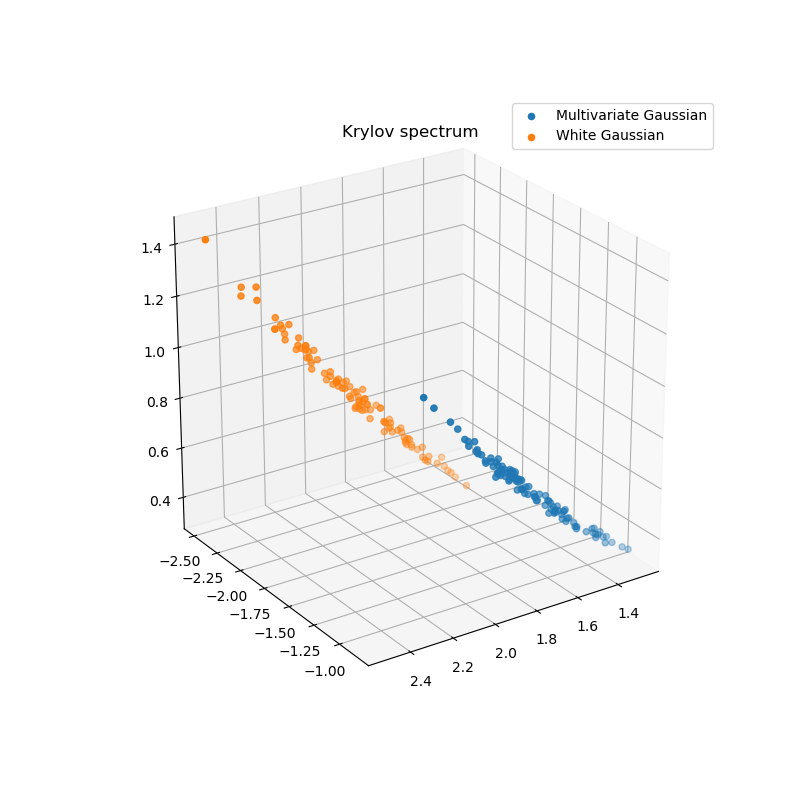

In [14]:
coef_dataset = xr.load_dataset('krylov spectrum/opening_angle_dataset.nc')

%matplotlib notebook
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('Krylov spectrum')
ax.scatter(*list(zip(*coefs_mvg))[:3], label='Multivariate Gaussian')
ax.scatter(*list(zip(*coef_dataset.krylov8.sel(opening_angle=solver.diffusion.opening_angle)))[:3], 
           label='White Gaussian')
plt.legend(loc='best')

## Input videos

In [3]:
os.environ['IMAGEIO_FFMPEG_EXE']='/usr/bin/ffmpeg/'

In [4]:
directory = '../../ActivityNet/Crawler/Kinetics/small_dataset/test/-7XsXx1jZ_g_000044_000054.mp4'

filename = directory
vid = imageio.get_reader(filename,  'ffmpeg')


ImportError: To use the imageio ffmpeg plugin you need to 'pip install imageio-ffmpeg'